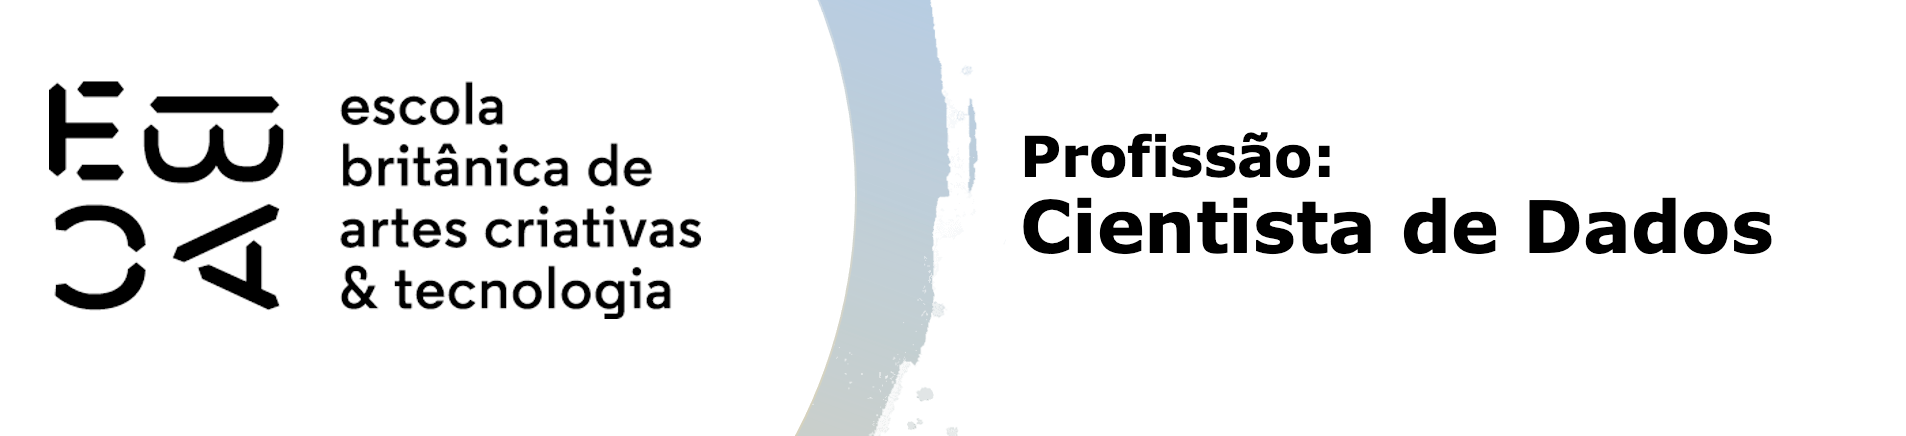

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_pickle('base_nfp.pkl')
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


In [5]:
# Informaçoes Gerais:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187646 entries, 0 to 187645
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   CNPJ emit.           187646 non-null  object        
 1   Emitente             187646 non-null  object        
 2   No.                  187646 non-null  int64         
 3   Data Emissão         187646 non-null  datetime64[ns]
 4   Valor NF             187646 non-null  float64       
 5   Data Registro        187646 non-null  datetime64[ns]
 6   Créditos             187646 non-null  float64       
 7   Situação do Crédito  187646 non-null  category      
 8   Ano                  187646 non-null  int64         
 9   Semestre             187646 non-null  int64         
 10  Retorno              186666 non-null  float64       
 11  flag_credito         187646 non-null  int64         
 12  categoria            187646 non-null  object        
dtypes: category(1)

In [6]:
# Missing Values = existem 980 missing values na variavel retorno
df.isna().sum()

CNPJ emit.               0
Emitente                 0
No.                      0
Data Emissão             0
Valor NF                 0
Data Registro            0
Créditos                 0
Situação do Crédito      0
Ano                      0
Semestre                 0
Retorno                980
flag_credito             0
categoria                0
dtype: int64

In [7]:
# Tratamento dos missing values: removi as linhas dos dados nulos pois significava 0,5% do dataset apenas
df = df.dropna()

## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [9]:
# Conversão da coluna de data para datetime 
df['Data Emissão'] = pd.to_datetime(df['Data Emissão'])

In [10]:
# Criação das variáveis temporais
df['dia_da_semana'] = df['Data Emissão'].dt.dayofweek  # 0 = Segunda, 6 = Domingo
df['fim_de_semana'] = df['dia_da_semana'].isin([5, 6]).astype(int)  # 1 se for sábado ou domingo
df['mes'] = df['Data Emissão'].dt.month
df['dia_do_mes'] = df['Data Emissão'].dt.day
df['trimestre'] = df['Data Emissão'].dt.quarter

In [11]:
# Crição das categorizações da variável "Valor NF" por quantis
df['valor_nf_q5'] = pd.qcut(df['Valor NF'], 5, labels=False)
df['valor_nf_q10'] = pd.qcut(df['Valor NF'], 10, labels=False)
df['valor_nf_q20'] = pd.qcut(df['Valor NF'], 20, labels=False)
df['valor_nf_q50'] = pd.qcut(df['Valor NF'], 50, labels=False)

In [12]:
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,...,categoria,dia_da_semana,fim_de_semana,mes,dia_do_mes,trimestre,valor_nf_q5,valor_nf_q10,valor_nf_q20,valor_nf_q50
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,...,Mercado,4,0,6,30,2,1,3,6,17
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,...,Auto posto,4,0,6,30,2,2,5,11,28
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,...,Restaurantes,4,0,6,30,2,1,3,7,18
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,...,Restaurantes,4,0,6,30,2,3,7,15,38
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,...,Restaurantes,4,0,6,30,2,3,7,15,39


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [14]:
df.columns

Index(['CNPJ emit.', 'Emitente', 'No.', 'Data Emissão', 'Valor NF',
       'Data Registro', 'Créditos', 'Situação do Crédito', 'Ano', 'Semestre',
       'Retorno', 'flag_credito', 'categoria', 'dia_da_semana',
       'fim_de_semana', 'mes', 'dia_do_mes', 'trimestre', 'valor_nf_q5',
       'valor_nf_q10', 'valor_nf_q20', 'valor_nf_q50'],
      dtype='object')

In [15]:
# Criaçao de metadados
df1 = df.drop(columns=['CNPJ emit.', 'Emitente', 'No.', 'Data Emissão', 'Valor NF',
       'Data Registro', 'Créditos', 'Situação do Crédito', 'Retorno'])
metadados = pd.DataFrame({'dtype': df1.dtypes})
metadados

,dtype
Ano,int64
Semestre,int64
flag_credito,int64
categoria,object
dia_da_semana,int32
fim_de_semana,int32
mes,int32
dia_do_mes,int32
trimestre,int32
valor_nf_q5,int64


In [16]:
# Atribuindo papeis
metadados['papel'] = 'covariavel'
metadados.loc['flag_credito', 'papel'] = 'resposta'
metadados['nunique'] = df.nunique()
metadados

,dtype,papel,nunique
Ano,int64,covariavel,5
Semestre,int64,covariavel,2
flag_credito,int64,resposta,2
categoria,object,covariavel,9
dia_da_semana,int32,covariavel,7
fim_de_semana,int32,covariavel,2
mes,int32,covariavel,12
dia_do_mes,int32,covariavel,31
trimestre,int32,covariavel,4
valor_nf_q5,int64,covariavel,5


In [17]:
# Funçao IV
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='Total')

    rotulo_evento = tab.columns[0]
    rotulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rotulo_evento]/tab.loc['Total', rotulo_evento]
    tab['pct_nao_evento'] = tab[rotulo_nao_evento]/tab.loc['Total', rotulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [18]:
iv_ano = IV(df.Ano, df.flag_credito)
iv_mes = IV(df.mes, df.flag_credito)
iv_Semestre = IV(df.Semestre, df.flag_credito)
iv_dia_da_semana = IV(df.dia_da_semana, df.flag_credito)
iv_fim_de_semana = IV(df.fim_de_semana, df.flag_credito)
iv_dia_do_mes = IV(df.dia_do_mes, df.flag_credito)
iv_trimestre = IV(df.trimestre, df.flag_credito)
iv_valor_nf_q5 = IV(df.valor_nf_q5, df.flag_credito)
iv_valor_nf_q10 = IV(df.valor_nf_q10, df.flag_credito)
iv_valor_nf_q20 = IV(df.valor_nf_q20, df.flag_credito)
iv_valor_nf_q50 = IV(df.valor_nf_q50, df.flag_credito)

print(f'iv_ano: {iv_ano}')
print(f'iv_mes: {iv_mes}')
print(f'iv_Semestre: {iv_Semestre}')
print(f'iv_dia_da_semana: {iv_dia_da_semana}')
print(f'iv_fim_de_semana: {iv_fim_de_semana}')
print(f'iv_dia_do_mes: {iv_dia_do_mes}')
print(f'iv_trimestre: {iv_trimestre}')
print(f'iv_valor_nf_q5: {iv_valor_nf_q5}')
print(f'iv_valor_nf_q10: {iv_valor_nf_q10}')
print(f'iv_valor_nf_q20: {iv_valor_nf_q20}')
print(f'iv_valor_nf_q50: {iv_valor_nf_q50}')

iv_ano: 0.04014148496338687
iv_mes: 0.02807591036036355
iv_Semestre: 0.0009251069414636032
iv_dia_da_semana: 0.00725282504121357
iv_fim_de_semana: 0.004703791653406019
iv_dia_do_mes: 0.043254388647592054
iv_trimestre: 0.011753740195325699
iv_valor_nf_q5: 0.05072521723423651
iv_valor_nf_q10: 0.09330743337402311
iv_valor_nf_q20: 0.11103248770728408
iv_valor_nf_q50: 0.1291053647288143


## Conclusão

<span style="color:blue; font-size:18px; font-weight:bold"> Análise do Information Value (IV) </span>

**Regras para interpretar o IV (segundo Naeem Siddiqi):**

| Faixa          | Poder preditivo |
|---------------|----------------|
| **0 a 0,02**  | Inútil         |
| **0,02 a 0,1** | Fraco         |
| **0,1 a 0,3**  | Médio         |
| **0,3 a 0,5**  | Forte         |
| **0,5 ou mais** | Suspeito de tão alto |

Analisando os IVs calculados, as variáveis que **mais se destacam** (medio) são:

- **iv_valor_nf_q50**: 0.1291053647288143
- **iv_valor_nf_q20**: 0.11103248770728408

As variáveis que são consideradas **fracas** com **IVs baixos (< 0.1)** são:
- **iv_ano**: 0.04014148496338687
- **iv_trimestre**: 0.011753740195325699
- **iv_mes**: 0.02807591036036355
- **iv_dia_do_mes**: 0.043254388647592054
- **iv_valor_nf_q5**: 0.05072521723423651
- **iv_valor_nf_q10**: 0.09330743337402311

As variáveis que são consideradas **inuteis** com **IVs baixos (< 0.02)** são:
- **iv_Semestre**: 0.0009251069414636032
- **iv_dia_da_semana**: 0.00725282504121357
- **iv_fim_de_semana**: 0.004703791653406019
 

**Relação entre número de categorias e o IV**  
Ao categorizar variáveis contínuas, observamos que **quanto mais categorias** uma variável tem, **maior tende a ser o IV**. 

**Conclusão:**  
- **Variáveis contínuas com mais categorias (como `valor_nf_q50`) tendem a ter IV maior.**  
- **Agrupar em poucas categorias pode fazer a variável perder poder preditivo.**  


## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

In [22]:
# A quantidade de notas registradas na base por período
notas_por_trimestre = df.groupby('trimestre').size()
notas_por_trimestre

trimestre
1    42314
2    42763
3    50977
4    50612
dtype: int64

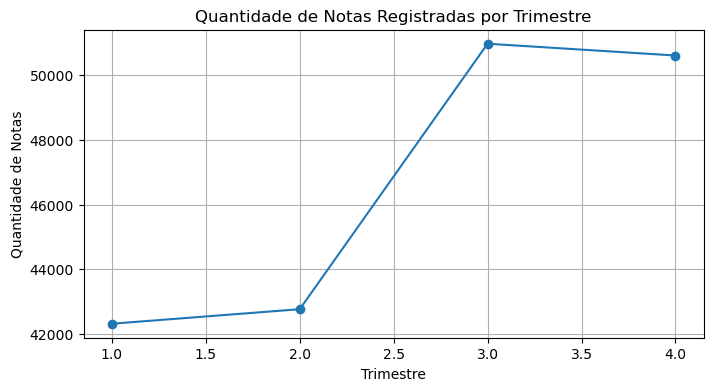

In [23]:
# Criando gráficos
fig, ax = plt.subplots(figsize=(8, 4))
notas_por_trimestre.plot(marker='o', linestyle='-')
ax.set_title("Quantidade de Notas Registradas por Trimestre")
ax.set_xlabel("Trimestre")
ax.set_ylabel("Quantidade de Notas")
ax.grid(True)
plt.show()

### Observaçoes:
- Houve um **crescimento significativo no 3º trimestre**, indicando sazonalidade.
- O **4º trimestre apresentou uma leve queda**, sugerindo uma estabilização após o pico anterior.

In [25]:
#A quantidade de notas por categoria e trimestre
notas_por_categoria_trim = df.groupby(['trimestre', 'categoria']).size().unstack()
notas_por_categoria_trim

categoria,Alimentos,Auto posto,Construção,Farmácia,Mercado,Restaurantes,Varejo,Vestuário,não definido
trimestre,,,,,,,,,
1,3686,1040,7294,3523,9728,9693,966,645,5739
2,4744,632,6494,3631,10007,8654,1161,811,6629
3,3655,1154,8948,3837,10565,12279,1350,950,8239
4,2874,863,9494,3949,12386,9122,1542,1200,9182


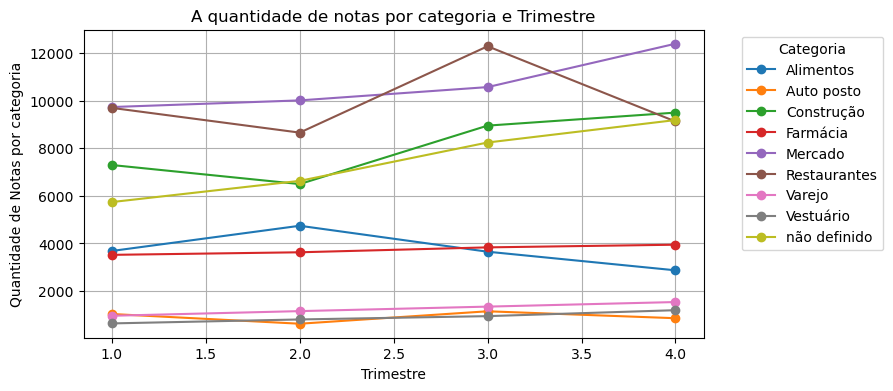

In [26]:
# Criando gráfico quantidade de notas por categoria e trimestre
fig, ax = plt.subplots(figsize=(8, 4))
notas_por_categoria_trim.plot(ax=ax, marker='o', linestyle='-')
ax.set_title("A quantidade de notas por categoria e Trimestre")
ax.set_xlabel("Trimestre")
ax.set_ylabel("Quantidade de Notas por categoria")
ax.grid(True)
plt.legend(title="Categoria", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Observaçoes:
- As categorias **Restaurantes**, **Mercado**, **Construçao** e **'Nao definido'** tiveram um aumento significativo no 3º trimestre
- **Restaurantes** teve aumento forte no 3º triestre porem uma forte queda no 4º Trimestre
- **Mercado** e **Construçao** e categoria **"não definido"** continuou crescendo no 4º Trimestre
- A categoria **Alimentos** houve queda apos subida no 2º Trimestre
- **Farmacia**,  **Varejo**, **Vestuario** e **Auto Posto** mantiveram um padrão mais regular, o que indica que essas categorias nao mudam muito pela sazonalidade

In [28]:
# A proporção de notas com crédito por categoria por período
proporcao_credito_por_categoria = df.groupby(['trimestre','categoria'])['flag_credito'].mean().unstack()
proporcao_credito_por_categoria

categoria,Alimentos,Auto posto,Construção,Farmácia,Mercado,Restaurantes,Varejo,Vestuário,não definido
trimestre,,,,,,,,,
1,0.875746,0.051923,0.398821,0.263412,0.443462,0.477148,0.217391,0.431008,0.434919
2,0.883010,0.094937,0.446412,0.298540,0.457180,0.399931,0.190353,0.484587,0.402474
3,0.857729,0.076256,0.368574,0.349752,0.483578,0.309146,0.210370,0.573684,0.445200
4,0.805846,0.079954,0.495576,0.387946,0.469078,0.573997,0.207523,0.485833,0.458506


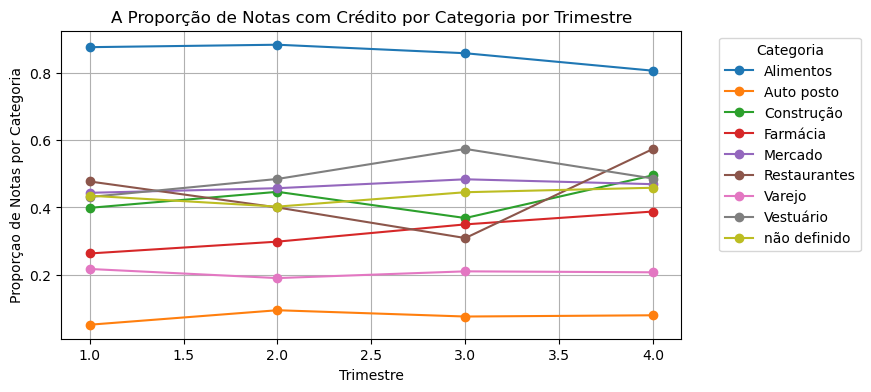

In [29]:
# Criando gráficos
fig, ax = plt.subplots(figsize=(8, 4))
proporcao_credito_por_categoria.plot(ax=ax, marker='o', linestyle='-')
ax.set_title("A Proporção de Notas com Crédito por Categoria por Trimestre")
ax.set_xlabel("Trimestre")
ax.set_ylabel("Proporçao de Notas por Categoria")
ax.grid(True)
plt.legend(title="Categoria", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Observaçoes:
- A categoria **Alimentos** tem a **maior proporçao** de notas com credito em todos os trimestres = forte impacto
- A categora **Auto Posto** tem a **menor proporção** de notas com credito
- **Vestuario** teve um aumento significativo no 3º trimestre mas no 4º ele volta a cair
- **Restaurante** teve uma queda significativa no 3º trimestre e recuperação no 4º trimestre
- **Varejo** e **Mercado** se mantem estaveis em todos trimestres

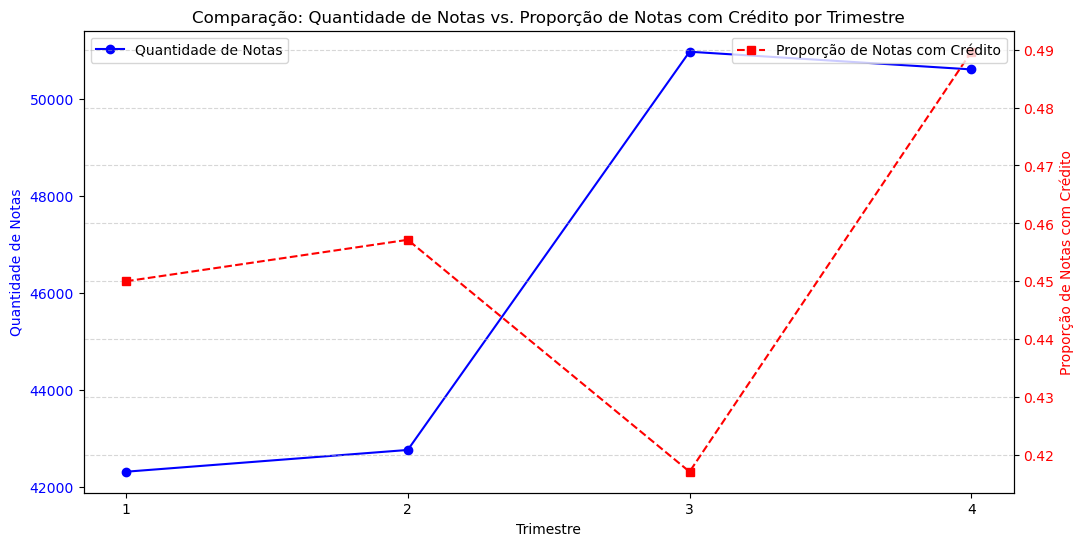

In [31]:
# Grafico de comparação da quantidade de notas e a proporção de notas com crédito por trimestre

# Calculando a quantidade total de notas por trimestre
quantidade_notas_por_trimestre = df.groupby('trimestre').size()

# Calculando a proporção de notas com crédito por trimestre
proporcao_notas_credito_por_trimestre = df.groupby('trimestre')['flag_credito'].mean()

# Criando o gráfico
fig, ax1 = plt.subplots(figsize=(12, 6))

# Gráfico de quantidade de notas (linha azul)
ax1.plot(quantidade_notas_por_trimestre.index.astype(str), quantidade_notas_por_trimestre.values, 
         marker='o', linestyle='-', color='blue', label="Quantidade de Notas")
ax1.set_xlabel("Trimestre")
ax1.set_ylabel("Quantidade de Notas", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Criando um segundo eixo Y para a proporção de notas com crédito
ax2 = ax1.twinx()
ax2.plot(proporcao_notas_credito_por_trimestre.index.astype(str), proporcao_notas_credito_por_trimestre.values, 
         marker='s', linestyle='--', color='red', label="Proporção de Notas com Crédito")
ax2.set_ylabel("Proporção de Notas com Crédito", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Adicionando título e legenda
plt.title("Comparação: Quantidade de Notas vs. Proporção de Notas com Crédito por Trimestre")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Exibir o gráfico
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


### Principais Observações
- **Aumento** significativo na quantidade de notas no **3º trimestre**, subindo de aproximadamente 43.000 para mais de 50.000 notas
- Apesar do aumento de notas, a **proporção de notas com crédito caiu** para o nível mais baixo do período analisado
- Isso sugere que nem todas as notas adicionais geradas foram elegíveis para crédito
- No **4º trimestre**, a quantidade total de notas teve uma leve queda, mas a proporção de notas com crédito **aumentou** significativamente.

### Conclusão
- O aumento da quantidade de notas não significou um aumento na proporção de crédito.
- A queda na proporção no 3º trimestre sugere que mais notas foram geradas, mas com menor chance de receber crédito.
- Recuperação da proporção de notas com crédito no 4º trimestre

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

### Analise da variavel Categoria no tempo ANO

In [35]:
# Analise do WOE e IV por ano na variavel categoria
tab_categoria = pd.crosstab([df['Ano'], df['categoria']], df['flag_credito'])
tab_categoria.reset_index()
tab_categoria

flag_credito           0     1
Ano  categoria                
2017 Alimentos        71  4875
     Auto posto     2480     9
     Construção     2712   505
     Farmácia       1609   343
     Mercado        2822  1084
     Restaurantes  15291  9482
     Varejo           66    11
     Vestuário         7   163
     não definido   1130   946
2018 Alimentos        97   227
     Auto posto      194    23
     Construção      381   447
     Farmácia        134   220
     Mercado        1776  2105
     Restaurantes   1316   934
     Varejo           73    32
     Vestuário        36   318
     não definido    732   567
2019 Alimentos       318  4324
     Auto posto      340   104
     Construção     6806  5336
     Farmácia       1707   741
     Mercado        3906  3442
     Restaurantes   5471  5076
     Varejo          364   291
     Vestuário       292   875
     não definido   3227  4840
2020 Alimentos       778  1720
     Auto posto      195    73
     Construção     4259  3448
     Farmácia       3669  1213
     Mercado        7617  6182
     Restaurantes    237   953
     Varejo         1314   362
     Vestuário       653   202
     não definido   5351  3361
2021 Alimentos       827  1722
     Auto posto      209    62
     Construção     4261  4075
     Farmácia       2935  2369
     Mercado        6757  6995
     Restaurantes    315   673
     Varejo         2167   339
     Vestuário       819   241
     não definido   6307  3328

In [36]:
# Proporção de notas que tiveram flag_credito por categoria de estabelecimento
tab_categoria['tx_evento'] = tab_categoria[1]/(tab_categoria[0] + tab_categoria[1])
tab_categoria

flag_credito           0     1  tx_evento
Ano  categoria                           
2017 Alimentos        71  4875   0.985645
     Auto posto     2480     9   0.003616
     Construção     2712   505   0.156979
     Farmácia       1609   343   0.175717
     Mercado        2822  1084   0.277522
     Restaurantes  15291  9482   0.382755
     Varejo           66    11   0.142857
     Vestuário         7   163   0.958824
     não definido   1130   946   0.455684
2018 Alimentos        97   227   0.700617
     Auto posto      194    23   0.105991
     Construção      381   447   0.539855
     Farmácia        134   220   0.621469
     Mercado        1776  2105   0.542386
     Restaurantes   1316   934   0.415111
     Varejo           73    32   0.304762
     Vestuário        36   318   0.898305
     não definido    732   567   0.436490
2019 Alimentos       318  4324   0.931495
     Auto posto      340   104   0.234234
     Construção     6806  5336   0.439466
     Farmácia       1707   741   0.302696
     Mercado        3906  3442   0.468427
     Restaurantes   5471  5076   0.481274
     Varejo          364   291   0.444275
     Vestuário       292   875   0.749786
     não definido   3227  4840   0.599975
2020 Alimentos       778  1720   0.688551
     Auto posto      195    73   0.272388
     Construção     4259  3448   0.447385
     Farmácia       3669  1213   0.248464
     Mercado        7617  6182   0.448003
     Restaurantes    237   953   0.800840
     Varejo         1314   362   0.215990
     Vestuário       653   202   0.236257
     não definido   5351  3361   0.385790
2021 Alimentos       827  1722   0.675559
     Auto posto      209    62   0.228782
     Construção     4261  4075   0.488844
     Farmácia       2935  2369   0.446644
     Mercado        6757  6995   0.508653
     Restaurantes    315   673   0.681174
     Varejo         2167   339   0.135275
     Vestuário       819   241   0.227358
     não definido   6307  3328   0.345407

In [37]:
# Calculo do WOE
rotulo_ev, rotulo_nev = (1, 0)

tab_categoria['pct_evento'] = tab_categoria[rotulo_ev]/tab_categoria[rotulo_ev].groupby(level=0).sum()
tab_categoria['pct_nao_evento'] = tab_categoria[rotulo_nev]/tab_categoria[rotulo_nev].groupby(level=0).sum()
tab_categoria['WOE'] = np.log(tab_categoria.pct_evento/tab_categoria.pct_nao_evento)
tab_categoria

flag_credito           0     1  tx_evento  pct_evento  pct_nao_evento  \
Ano  categoria                                                          
2017 Alimentos        71  4875   0.985645    0.279883        0.002711   
     Auto posto     2480     9   0.003616    0.000517        0.094700   
     Construção     2712   505   0.156979    0.028993        0.103559   
     Farmácia       1609   343   0.175717    0.019692        0.061440   
     Mercado        2822  1084   0.277522    0.062234        0.107759   
     Restaurantes  15291  9482   0.382755    0.544379        0.583893   
     Varejo           66    11   0.142857    0.000632        0.002520   
     Vestuário         7   163   0.958824    0.009358        0.000267   
     não definido   1130   946   0.455684    0.054312        0.043150   
2018 Alimentos        97   227   0.700617    0.046583        0.020468   
     Auto posto      194    23   0.105991    0.004720        0.040937   
     Construção      381   447   0.539855    0.091730        0.080397   
     Farmácia        134   220   0.621469    0.045147        0.028276   
     Mercado        1776  2105   0.542386    0.431972        0.374763   
     Restaurantes   1316   934   0.415111    0.191668        0.277696   
     Varejo           73    32   0.304762    0.006567        0.015404   
     Vestuário        36   318   0.898305    0.065258        0.007597   
     não definido    732   567   0.436490    0.116355        0.154463   
2019 Alimentos       318  4324   0.931495    0.172760        0.014177   
     Auto posto      340   104   0.234234    0.004155        0.015158   
     Construção     6806  5336   0.439466    0.213193        0.303419   
     Farmácia       1707   741   0.302696    0.029606        0.076100   
     Mercado        3906  3442   0.468427    0.137520        0.174134   
     Restaurantes   5471  5076   0.481274    0.202805        0.243904   
     Varejo          364   291   0.444275    0.011627        0.016228   
     Vestuário       292   875   0.749786    0.034959        0.013018   
     não definido   3227  4840   0.599975    0.193376        0.143863   
2020 Alimentos       778  1720   0.688551    0.098207        0.032318   
     Auto posto      195    73   0.272388    0.004168        0.008100   
     Construção     4259  3448   0.447385    0.196871        0.176920   
     Farmácia       3669  1213   0.248464    0.069259        0.152411   
     Mercado        7617  6182   0.448003    0.352975        0.316413   
     Restaurantes    237   953   0.800840    0.054414        0.009845   
     Varejo         1314   362   0.215990    0.020669        0.054584   
     Vestuário       653   202   0.236257    0.011534        0.027126   
     não definido   5351  3361   0.385790    0.191904        0.222282   
2021 Alimentos       827  1722   0.675559    0.086952        0.033622   
     Auto posto      209    62   0.228782    0.003131        0.008497   
     Construção     4261  4075   0.488844    0.205767        0.173233   
     Farmácia       2935  2369   0.446644    0.119622        0.119323   
     Mercado        6757  6995   0.508653    0.353211        0.274708   
     Restaurantes    315   673   0.681174    0.033983        0.012806   
     Varejo         2167   339   0.135275    0.017118        0.088100   
     Vestuário       819   241   0.227358    0.012169        0.033297   
     não definido   6307  3328   0.345407    0.168047        0.256413   

flag_credito            WOE  
Ano  categoria               
2017 Alimentos     4.636993  
     Auto posto   -5.210992  
     Construção   -1.273086  
     Farmácia     -1.137841  
     Mercado      -0.548991  
     Restaurantes -0.070072  
     Varejo       -1.383962  
     Vestuário     3.555637  
     não definido  0.230067  
2018 Alimentos     0.822355  
     Auto posto   -2.160248  
     Construção    0.131876  
     Farmácia      0.467904  
     Mercado       0.142068  
     Restaurantes -0.370759  
     Varejo       -0.852607  
     Vestuário     2.150649 

In [38]:
# Calculo do IV
tab_categoria['iv_cat'] = (tab_categoria['pct_evento'] - tab_categoria['pct_nao_evento']) * tab_categoria['WOE']
tab_categoria

flag_credito           0     1  tx_evento  pct_evento  pct_nao_evento  \
Ano  categoria                                                          
2017 Alimentos        71  4875   0.985645    0.279883        0.002711   
     Auto posto     2480     9   0.003616    0.000517        0.094700   
     Construção     2712   505   0.156979    0.028993        0.103559   
     Farmácia       1609   343   0.175717    0.019692        0.061440   
     Mercado        2822  1084   0.277522    0.062234        0.107759   
     Restaurantes  15291  9482   0.382755    0.544379        0.583893   
     Varejo           66    11   0.142857    0.000632        0.002520   
     Vestuário         7   163   0.958824    0.009358        0.000267   
     não definido   1130   946   0.455684    0.054312        0.043150   
2018 Alimentos        97   227   0.700617    0.046583        0.020468   
     Auto posto      194    23   0.105991    0.004720        0.040937   
     Construção      381   447   0.539855    0.091730        0.080397   
     Farmácia        134   220   0.621469    0.045147        0.028276   
     Mercado        1776  2105   0.542386    0.431972        0.374763   
     Restaurantes   1316   934   0.415111    0.191668        0.277696   
     Varejo           73    32   0.304762    0.006567        0.015404   
     Vestuário        36   318   0.898305    0.065258        0.007597   
     não definido    732   567   0.436490    0.116355        0.154463   
2019 Alimentos       318  4324   0.931495    0.172760        0.014177   
     Auto posto      340   104   0.234234    0.004155        0.015158   
     Construção     6806  5336   0.439466    0.213193        0.303419   
     Farmácia       1707   741   0.302696    0.029606        0.076100   
     Mercado        3906  3442   0.468427    0.137520        0.174134   
     Restaurantes   5471  5076   0.481274    0.202805        0.243904   
     Varejo          364   291   0.444275    0.011627        0.016228   
     Vestuário       292   875   0.749786    0.034959        0.013018   
     não definido   3227  4840   0.599975    0.193376        0.143863   
2020 Alimentos       778  1720   0.688551    0.098207        0.032318   
     Auto posto      195    73   0.272388    0.004168        0.008100   
     Construção     4259  3448   0.447385    0.196871        0.176920   
     Farmácia       3669  1213   0.248464    0.069259        0.152411   
     Mercado        7617  6182   0.448003    0.352975        0.316413   
     Restaurantes    237   953   0.800840    0.054414        0.009845   
     Varejo         1314   362   0.215990    0.020669        0.054584   
     Vestuário       653   202   0.236257    0.011534        0.027126   
     não definido   5351  3361   0.385790    0.191904        0.222282   
2021 Alimentos       827  1722   0.675559    0.086952        0.033622   
     Auto posto      209    62   0.228782    0.003131        0.008497   
     Construção     4261  4075   0.488844    0.205767        0.173233   
     Farmácia       2935  2369   0.446644    0.119622        0.119323   
     Mercado        6757  6995   0.508653    0.353211        0.274708   
     Restaurantes    315   673   0.681174    0.033983        0.012806   
     Varejo         2167   339   0.135275    0.017118        0.088100   
     Vestuário       819   241   0.227358    0.012169        0.033297   
     não definido   6307  3328   0.345407    0.168047        0.256413   

flag_credito            WOE        iv_cat  
Ano  categoria                             
2017 Alimentos     4.636993  1.285243e+00  
     Auto posto   -5.210992  4.907877e-01  
     Construção   -1.273086  9.492879e-02  
     Farmácia     -1.137841  4.750266e-02  
     Mercado      -0.548991  2.499270e-02  
     Restaurantes -0.070072  2.768826e-03  
     Varejo       -1.383962  2.613900e-03  
     Vestuário     3.555637  3.232372e-02  
     não definido  0.230067  2.568028e-03  
2018 Alimentos     0.822355  2.147561e-02  
     Auto posto   -2.160248  7.823773e-0

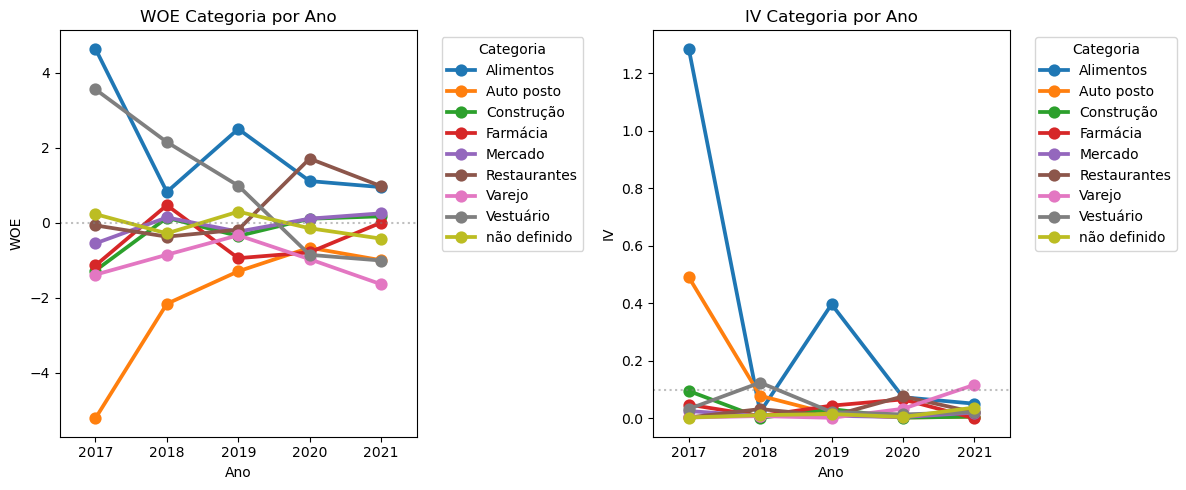

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de WOE
sns.pointplot(data=tab_categoria.reset_index(), x='Ano', y='WOE', hue='categoria', ax=axes[0])
axes[0].axhline(0, linestyle=':', color='gray', alpha=0.5)
axes[0].set_title("WOE Categoria por Ano")
axes[0].set_xlabel("Ano")
axes[0].set_ylabel("WOE")
axes[0].legend(title="Categoria", bbox_to_anchor=(1.05, 1), loc='upper left')

# Gráfico de IV
sns.pointplot(data=tab_categoria.reset_index(), x='Ano', y='iv_cat', hue='categoria', ax=axes[1])
axes[1].axhline(0.1, linestyle=':', color='gray', alpha=0.5)
axes[1].set_title("IV Categoria por Ano")
axes[1].set_xlabel("Ano")
axes[1].set_ylabel("IV")
axes[1].legend(title="Categoria", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


### Análise dos Graficos
- O grafico da esquerda mostra o **WOE(Weight of Evidence)**, que indica a relaçao de cada categoria com notas que recebem ou não credito
- O grafico da direita mostra o **IV(Information Value)**, que mede o poder preditivo das categorias

### Observações:
- Foi observado que as categorias que tem WOE alto positivo (Alimentos) ou negativos (Auto Posto) impacta no IV tendo um IV maior
- A maioria das categorias estao no WOE proximo de 0, resultando num IV baixo
- O proximo gráfico vai nos mostrar a relacao de WOE com IV

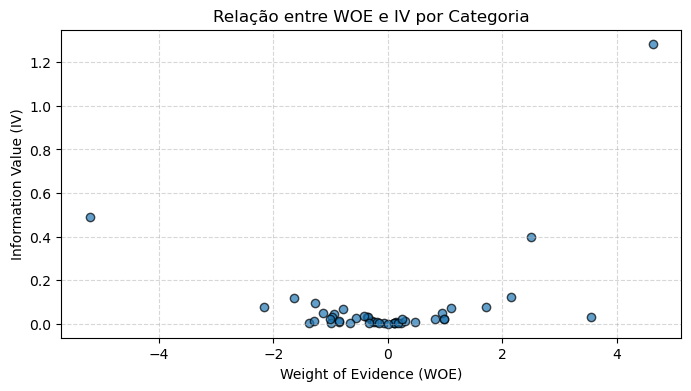

In [41]:
# Criando um gráfico de dispersão para relacionar WOE e IV
plt.figure(figsize=(8, 4))
plt.scatter(tab_categoria['WOE'], tab_categoria['iv_cat'], alpha=0.7, edgecolors='k')

# Adicionando rótulos e título
plt.xlabel("Weight of Evidence (WOE)")
plt.ylabel("Information Value (IV)")
plt.title("Relação entre WOE e IV por Categoria")

# Grid para melhor visualização
plt.grid(True, linestyle="--", alpha=0.5)

# Exibir gráfico
plt.show()


In [42]:
iv_cat = tab_categoria['iv_cat'].groupby(level=0).sum();  # Soma do IV por trimestre
iv_cat

Ano
2017    1.983730
2018    0.291464
2019    0.540560
2020    0.274489
2021    0.276930
Name: iv_cat, dtype: float64

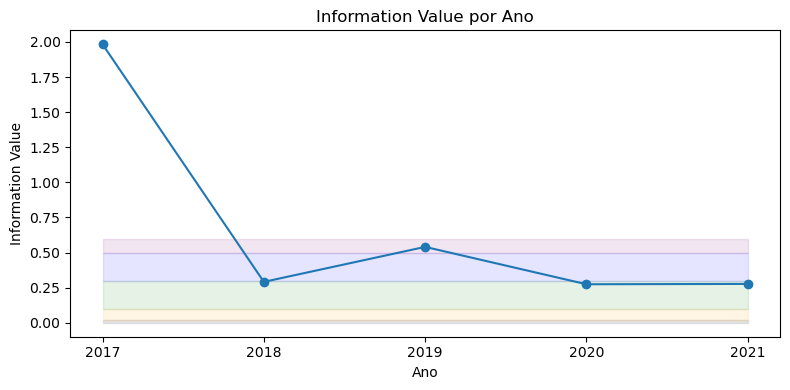

In [43]:
def plot_iv(IV):
    fig, ax = plt.subplots(figsize=(8, 4))
    
    x = IV.index.astype(str)  
    a = [.02] * len(x)
    b = [.1] * len(x)
    c = [.3] * len(x)
    d = [.5] * len(x)
    e = [.6] * len(x)

    ax.fill_between(x, a, color='grey', alpha=.2)
    ax.fill_between(x, a, b, color='orange', alpha=.1)
    ax.fill_between(x, b, c, color='green', alpha=.1)
    ax.fill_between(x, c, d, color='blue', alpha=.1)
    ax.fill_between(x, d, e, color='purple', alpha=.1)
    ax.plot(x, IV, marker='o', linestyle='-')

    ax.set_title("Information Value por Ano")
    ax.set_ylabel("Information Value")
    ax.set_xlabel("Ano")

    plt.tight_layout()
    plt.show()

plot_iv(iv_cat)


### Observações:
1. O IV era extremamente alto em 2017, mas caiu drasticamente em 2018:
    - Em 2017, o IV estava acima de 2.0, indicando que a variável tinha forte poder preditivo.
    - A partir de 2018, houve uma queda brusca, reduzindo o IV para um nível muito menor (~0.3).
    - Isso pode sugerir mudanças nas regras de concessão de crédito ou no comportamento dos consumidores.
2. Pequena recuperação em 2019, seguida por queda em 2020 e se mantendo em 2021 
    - Em 2019, o IV teve uma leve alta (~0.5), mas voltou a cair em 2020 e se estabilizou no ano 2021
    - Em 2020 houve a pandemia, que pode ser um indicador da queda e mudanca de padrao de consumo que se estende ate os dias atuais
3. Farei a analise dos dados a partir do ano de 2020, que é mais parecido com o publico atual

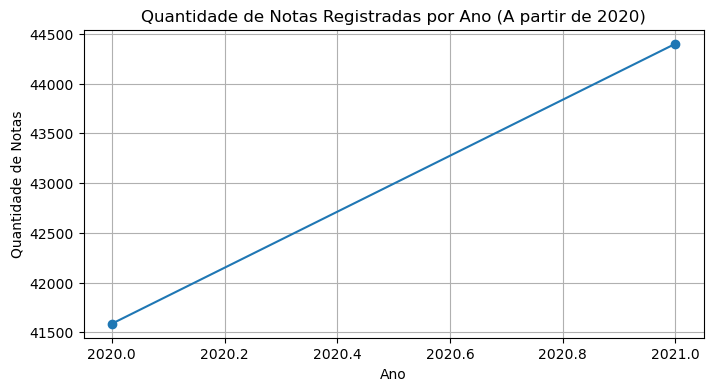

In [45]:
# A quantidade de notas registradas na base por período Ano a partir de 2020
notas_por_ano = df.groupby('Ano').size()
notas_por_ano = notas_por_ano[notas_por_ano.index >= 2020] 

# Criando gráficos
fig, ax = plt.subplots(figsize=(8, 4))
notas_por_ano.plot(marker='o', linestyle='-')
ax.set_title("Quantidade de Notas Registradas por Ano (A partir de 2020)")
ax.set_xlabel("Ano")
ax.set_ylabel("Quantidade de Notas")
ax.grid(True)
plt.show()

In [46]:
#A quantidade de notas por categoria e Ano
notas_por_categoria_ano = df.groupby(['Ano', 'categoria']).size().unstack()
#Filtrando apenas anos a partir de 2020
notas_por_categoria_ano = notas_por_categoria_ano.loc[notas_por_categoria_ano.index >= 2020]
notas_por_categoria_ano

categoria,Alimentos,Auto posto,Construção,Farmácia,Mercado,Restaurantes,Varejo,Vestuário,não definido
Ano,,,,,,,,,
2020,2498,268,7707,4882,13799,1190,1676,855,8712
2021,2549,271,8336,5304,13752,988,2506,1060,9635


In [47]:
# A proporção de notas com crédito por categoria por período
proporcao_credito_por_ano = df.groupby(['Ano','categoria'])['flag_credito'].mean().unstack()
# Filtrando apenas anos a partir de 2020
proporcao_credito_por_ano = proporcao_credito_por_ano.loc[proporcao_credito_por_ano.index >= 2020]
proporcao_credito_por_ano

categoria,Alimentos,Auto posto,Construção,Farmácia,Mercado,Restaurantes,Varejo,Vestuário,não definido
Ano,,,,,,,,,
2020,0.688551,0.272388,0.447385,0.248464,0.448003,0.800840,0.215990,0.236257,0.385790
2021,0.675559,0.228782,0.488844,0.446644,0.508653,0.681174,0.135275,0.227358,0.345407


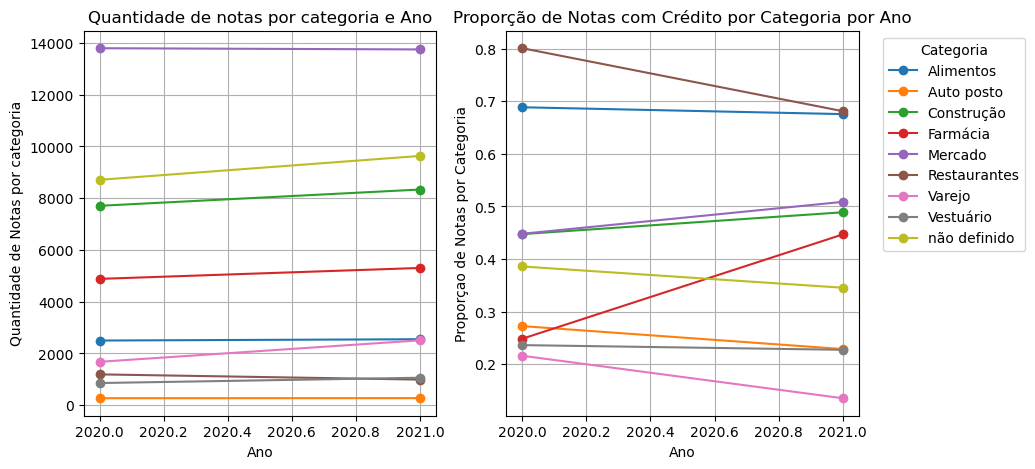

In [48]:
# Criando gráfico quantidade de notas por categoria e Ano
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
notas_por_categoria_ano.plot(ax=axes[0], marker='o', linestyle='-')
axes[0].set_title("Quantidade de notas por categoria e Ano")
axes[0].set_xlabel("Ano")
axes[0].set_ylabel("Quantidade de Notas por categoria")
axes[0].grid(True)
axes[0].get_legend().remove()

# Criando gráfico de proporcao de notas por categoria e Ano
proporcao_credito_por_ano.plot(ax=axes[1], marker='o', linestyle='-')
axes[1].set_title("Proporção de Notas com Crédito por Categoria por Ano")
axes[1].set_xlabel("Ano")
axes[1].set_ylabel("Proporçao de Notas por Categoria")
axes[1].grid(True)

plt.legend(title="Categoria", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Conclusão Final: 

Proporçao de notas com retornos maiores que zero são:
| Categoria      | 2020     | 2021     |
|---------------|---------|---------|
| Alimentos     | 0.688551 | 0.675559 |
| Auto Posto    | 0.272388 | 0.228782 |
| Construção    | 0.447385 | 0.488844 |
| Farmácia      | 0.248464 | 0.446644 |
| Mercado       | 0.448003 | 0.508653 |
| Restaurantes  | 0.800840 | 0.681174 |
| Varejo        | 0.215990 | 0.135275 |
| Vestuário     | 0.236257 | 0.227358 |
| Não Definido  | 0.385790 | 0.345407 |


- As categorias com maior proporção de notas com retorno positivo foram **"Restaurantes"** e **"Alimentos"** em 2020, mas perderam força em 2021.
- As categorias **"Farmácia"** e **"Construção"** aumentaram sua participação na concessão de crédito.
- **"Auto Posto"** e **"Vestuário"** continuam sendo os setores menos favorecidos na concessão de crédito.
- As diferenças entre categorias não são completamente estáveis ao longo do tempo, pois observamos mudanças no padrão de concessão de crédito.
- A partir de 2020, os dados parecem mais estáveis e semelhantes ao cenário atual (2022), refletindo um público pós-pandemia com novos hábitos de consumo.